In [1]:
import os
import json
import argparse
import torch
import dataloaders
import models
import inspect
import math
from utils import losses
from utils import Logger
from utils.torchsummary import summary
from trainer import Trainer
import torch
import time
import numpy as np
from torchvision.utils import make_grid
from torchvision import transforms
from utils import transforms as local_transforms
from base import BaseTrainer, DataPrefetcher
from utils.helpers import colorize_mask
from utils.metrics import eval_metrics, AverageMeter
from tqdm import tqdm
import numpy as np
from poibin import PoiBin
from scipy.stats import binom, norm
import scipy
from rankdice import rank_dice
from tester import Tester
import matplotlib.pyplot as plt
import seaborn as sns
## test for the new things

In [4]:
def get_instance(module, name, config, *args):
    # GET THE CORRESPONDING CLASS / FCT
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

In [8]:
config = json.load(open('config.json'))
config['name'] = 'ENet'
config['arch']['type'] = 'ENet'
config['arch']['args']['backbone'] = 'resnet18'
config['test_loader']['args']['batch_size'] = 8
config['predict']['test'] = 'rankdice'
resume = './saved/ENet/CE_DiceLoss/02-08_11-57/best_model.pth'

test_logger = Logger()

# DATA LOADERS
test_loader = get_instance(dataloaders, 'test_loader', config)

# MODEL
model = get_instance(models, 'arch', config, test_loader.dataset.num_classes)
print(f'\n{model}\n')

# LOSS
loss = getattr(losses, config['loss'])(ignore_index = config['ignore_index'])


ENet(
  (initial): InitalBlock(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=16)
  )
  (bottleneck10): BottleNeck(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(16, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu1): PReLU(num_parameters=1)
    (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu2): PReLU(num_parameters=1)
    (conv3): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

Detected GPUs: 1 Requested: 1
Loading checkpoint : ./saved/ENet/CE_DiceLoss/02-08_11-57/best_model.pth
Checkpoint <./saved/ENet/CE_DiceLoss/02-08_11-57/best_model.pth> (epoch 471) was loaded
  0%|                                                                                                     | 0/182 [00:06<?, ?it/s]


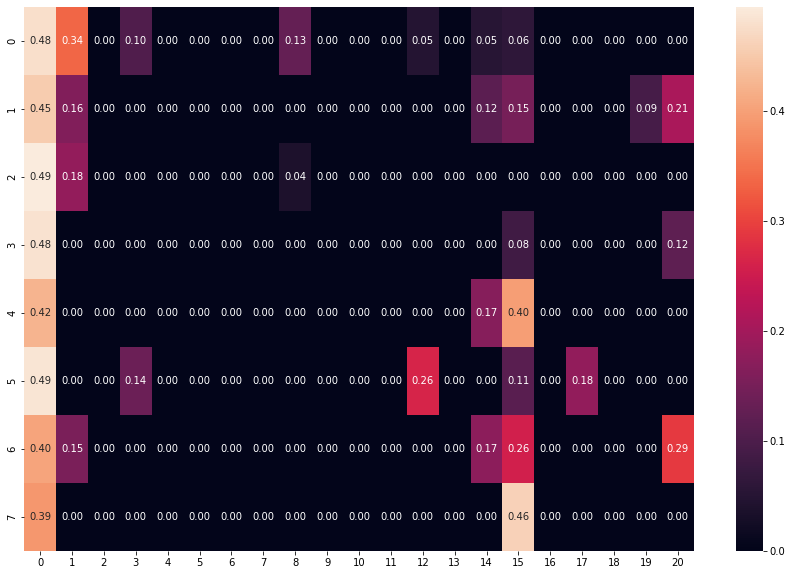

In [14]:
# TESTING
tester = Tester(
    model=model,
    loss=loss,
    resume=resume,
    config=config,
    test_loader=test_loader,
    test_logger=test_logger)

device = tester.device

# tester.test()
with torch.no_grad():
    tester._reset_metrics()
    tbar = tqdm(tester.test_loader, ncols=130)
    data, target = next(iter(tester.test_loader))
    num_class = tester.num_classes
    output = tester.model(data)
    _, predict = torch.max(output.data, 1)
    predict_rd, tau_rd, cutpoint_rd = rank_dice(output, app=2, device=tester.device)
    out_prob = output.softmax(dim=1)
    predict_T = torch.where(out_prob > .5, True, False)

## cutpoint of rankdice
plt.figure(figsize=(15,10))
ax = sns.heatmap(cutpoint_rd.data.cpu(), annot=True, fmt=".2f")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


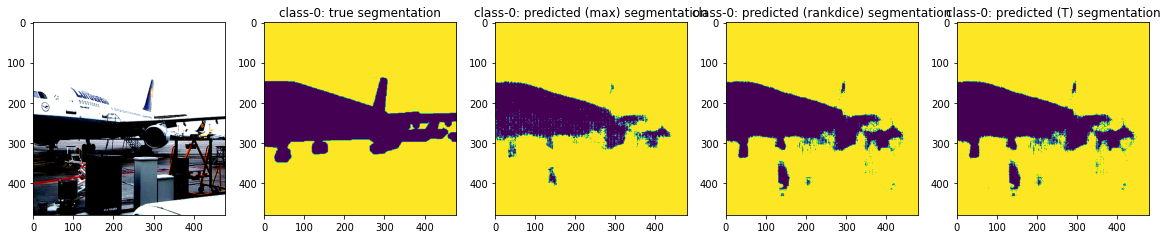

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


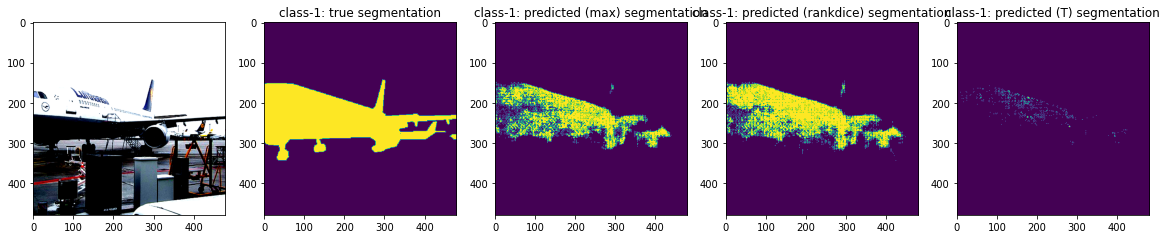

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


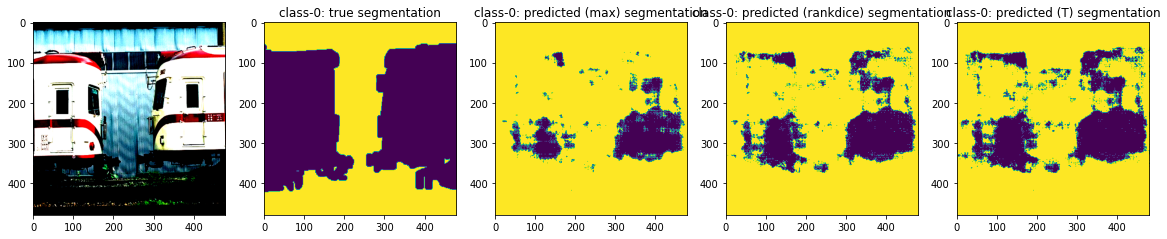

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


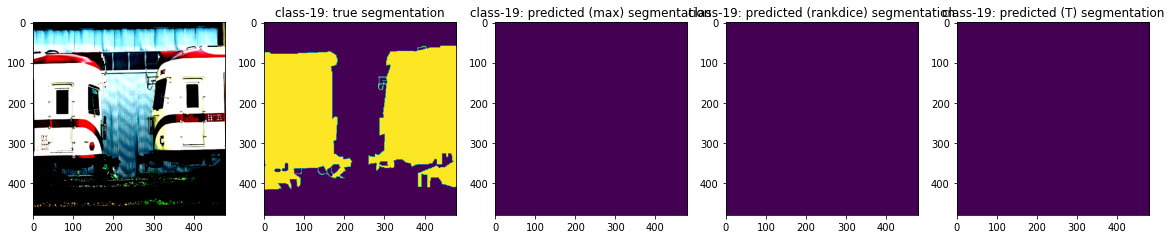

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


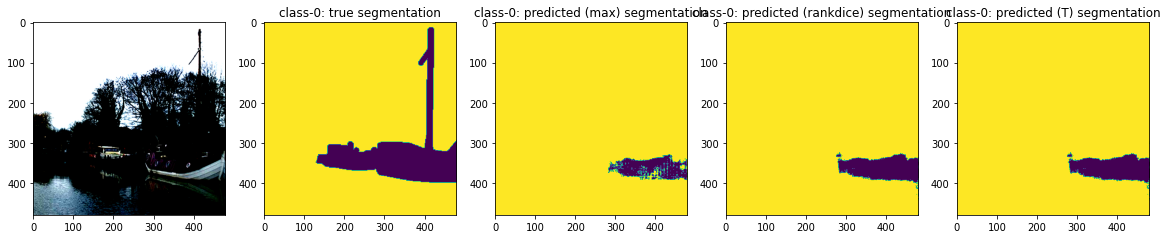

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


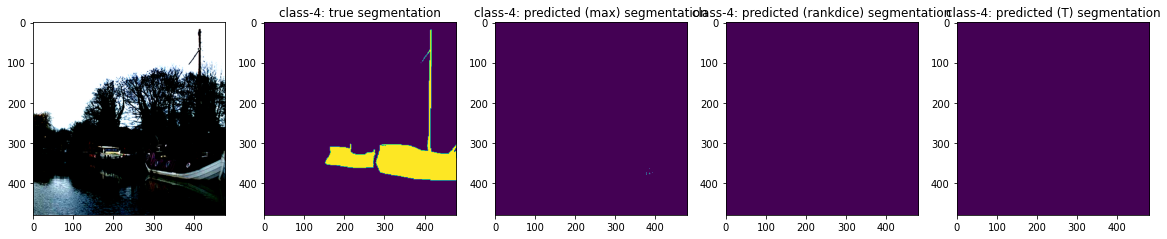

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


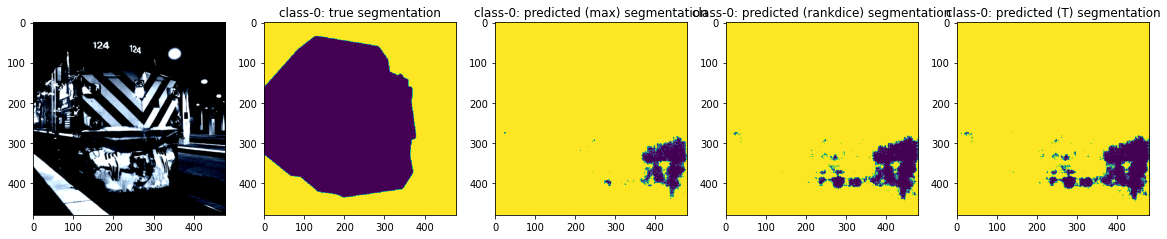

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


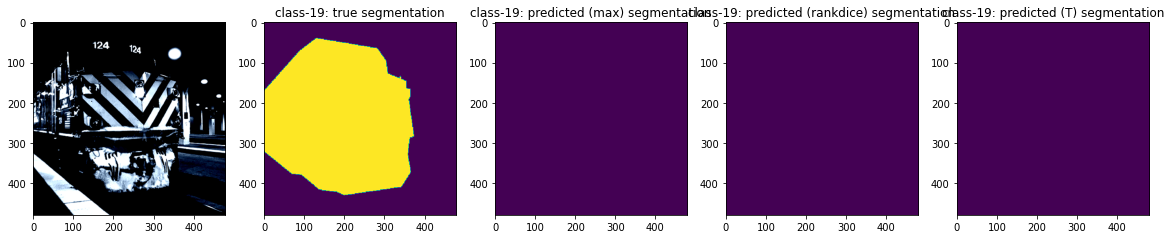

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


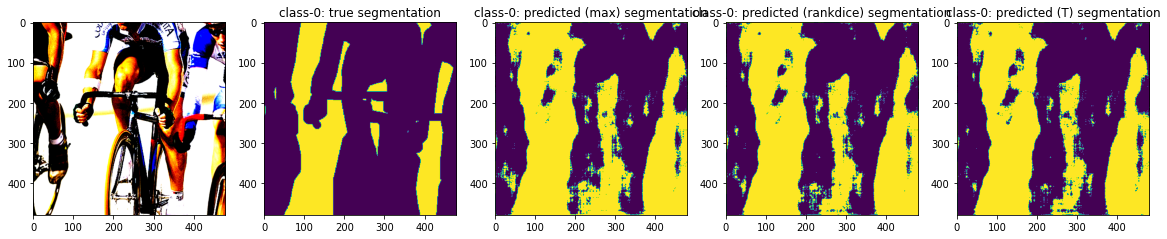

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


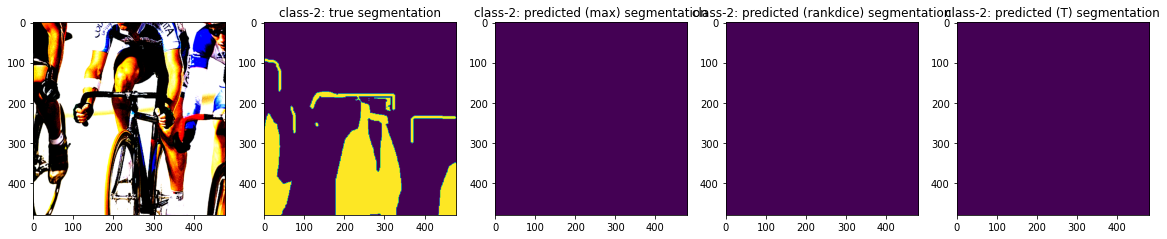

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


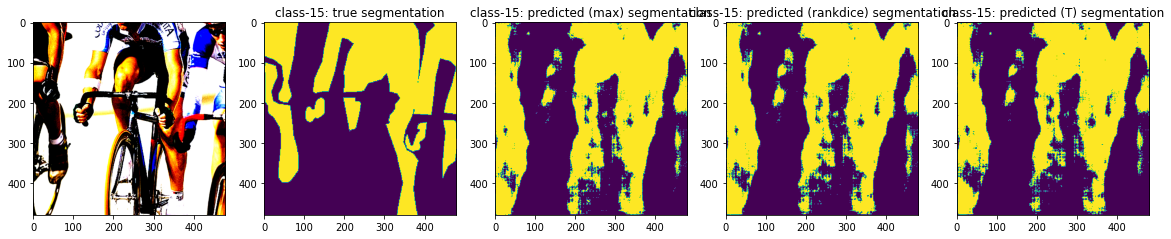

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


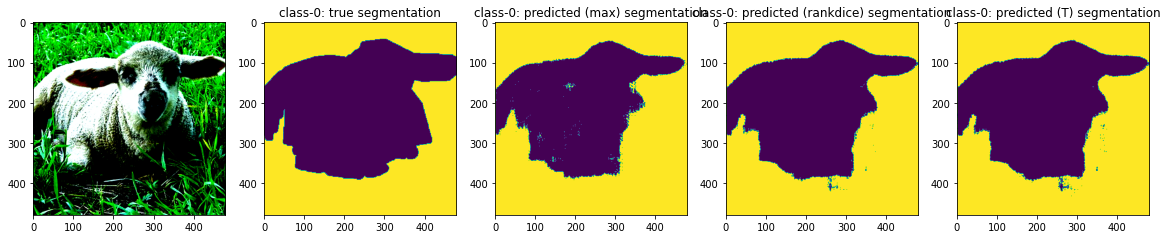

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


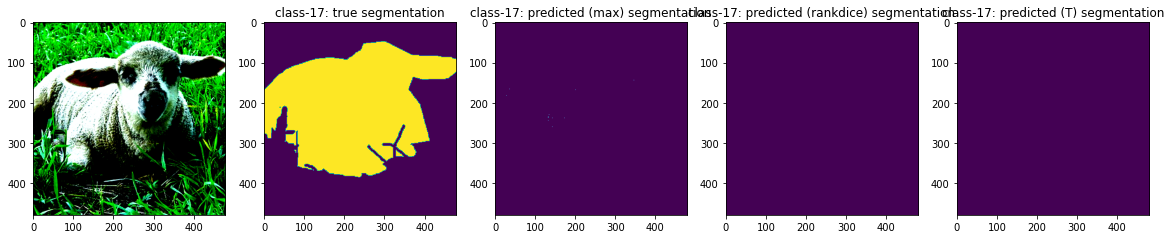

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


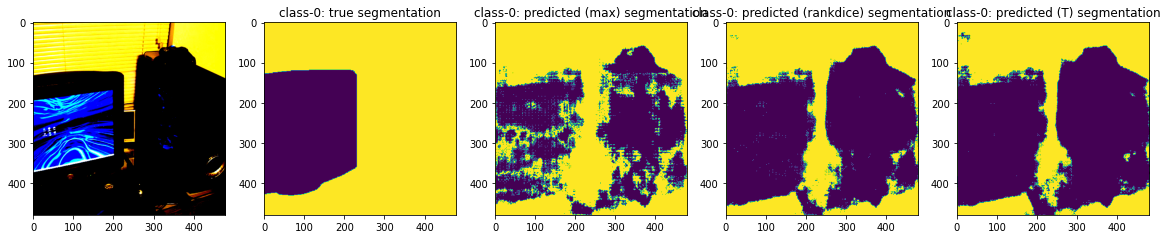

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


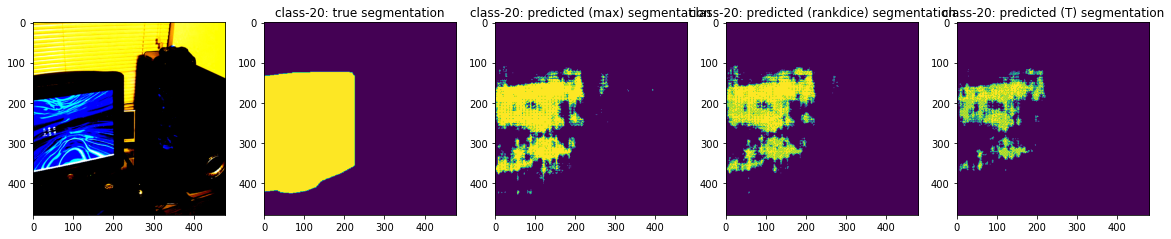

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


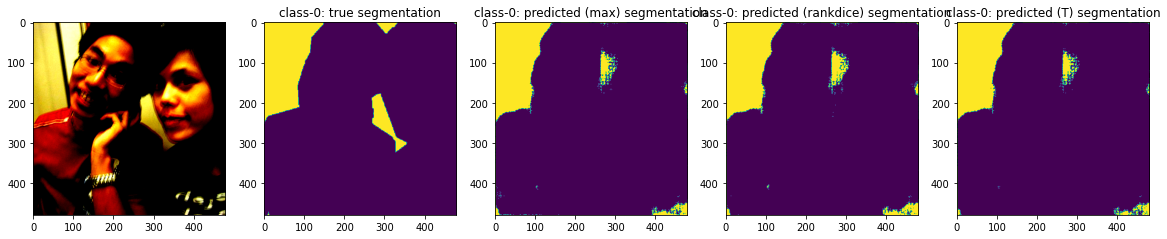

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


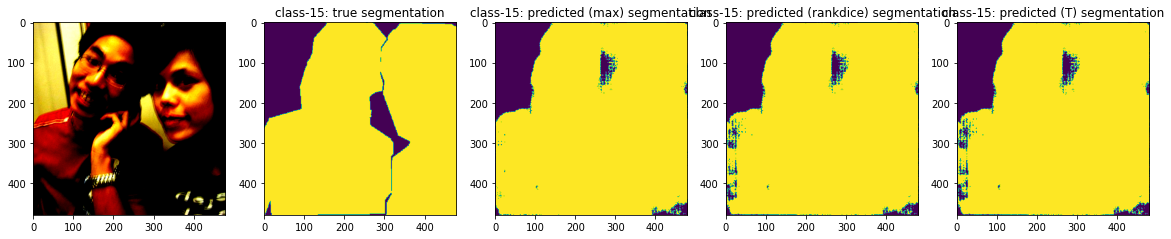

In [10]:
# vitualization
val_img = []
target_np, predict_np, predict_rd_np, predict_T_np = target.data.cpu(), predict.data.cpu(), predict_rd.data.cpu(), predict_T.data.cpu()
val_visual = [[data[i].data.cpu(), target_np[i], predict_np[i], predict_rd_np[i], predict_T_np[i]] for i in range(len(target_np))]
palette = tester.test_loader.dataset.palette
for d, t, o, o_rd, o_T in val_visual:
    # d = tester.restore_transform(d)
    # d = d.convert('RGB')
    # d = tester.viz_transform(d)
    for k in range(tester.num_classes):
        t_tmp = torch.where(t==k, True, False)
        o_tmp = torch.where(o==k, True, False)
        o_rd_tmp = o_rd[k]
        o_T_tmp = o_T[k]

        if t_tmp.sum() >= 1:
            fig, axes = plt.subplots(1,5, figsize=(20,4))
            axes[0].imshow(d.permute(1, 2, 0))
            axes[1].imshow(t_tmp)
            axes[2].imshow(o_tmp)
            axes[3].imshow(o_rd_tmp)
            axes[4].imshow(o_T_tmp)
            axes[1].set_title("class-%s: true segmentation" %k)
            axes[2].set_title("class-%s: predicted (max) segmentation" %k)
            axes[3].set_title("class-%s: predicted (rankdice) segmentation" %k)
            axes[4].set_title("class-%s: predicted (T) segmentation" %k) 
            plt.show()